In [1]:
cd ..

/home/msi/projects/diplomka


In [2]:
import pandas as pd
import glob
from datetime import datetime, timedelta
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
from itertools import count
import seaborn as sns
import netgraph as ng
from collections import defaultdict
from hashlib import sha1
import json
import pandas as pd
import netgraph as ng

In [3]:
from trct import TraceMonitor

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

np.printoptions(precision=2)

sns.set_style("darkgrid")
sns.set_context("paper")

# Get files

In [5]:
dataset = 'FZK_LCCG2-INFN_T1'
# dataset = 'CA_SFU_T2-CSCS_LCG2'

In [6]:
# files = sorted(glob.glob("data/sites/CA_SFU_T2-CSCS_LCG2/*.json"))
files = sorted(glob.glob(f"data/sites/{dataset}/*.json"))
len(files)

59591

In [7]:
with open(files[0], 'r') as f:
    data = json.load(f)

In [8]:
src, dest = data['src'], data['dest']

# Processing

In [9]:
files = sorted(
    # glob.glob("data/out/FZK_LCCG2-INF_T1/*.json")
    files
    )

In [10]:
with open(files[34840], "r") as f:
    json_data = json.load(f)

In [11]:
json_data

{'max_rtt': 22.2,
 'src_VO': 'ATLAS',
 'created_at': '2023-03-06T10:51:22.039887191Z',
 'dest': '2001:760:4205:254::12',
 'src_site': 'FZK-LCG2',
 'path_complete': False,
 'MA': '2a00:139c:5:585:0:41:2:12',
 'destination_reached': True,
 'ipv6': True,
 'dest_production': True,
 'asns': [58069, 513, 513, 137, 137],
 'n_hops': 5,
 'timestamp': 1678099518000,
 'src': '2a00:139c:5:585:0:41:2:12',
 'dest_site': 'INFN-T1',
 'dest_VO': 'ATLAS',
 'looping': False,
 'src_host': 'perfsonar2-de-kit.gridka.de',
 'push': False,
 'route-sha1': '73f6bc8562e69446c4456ee79ebc0de2e1cca5aa',
 'ttls': [1, 3, 4, 7, 15],
 'rtts': [0.9, 11.2, 18.3, 22.2, 20.6],
 'dest_host': 'perfsonar-ow.cnaf.infn.it',
 'hops': ['2a00:139c:5:585::3',
  '2001:1458:302:38::1',
  '2001:1458:302:27::2',
  '2001:760:ffff:110::25',
  '2001:760:4205:254::12'],
 'src_production': True}

In [12]:
ta = TraceMonitor(src, dest, dest_asn=0)

In [13]:
ta.process(files)

100%|██████████| 59591/59591 [00:13<00:00, 4551.38it/s]


In [14]:
meta_df = pd.read_csv(f"data/ip_metadata/{dataset}.csv")

In [15]:
meta_df[meta_df['ip'] == data['src']]

,status,continent,continentCode,country,countryCode,region,regionName,city,zip,lat,lon,timezone,isp,org,as,asname,mobile,proxy,hosting,ip
0,success,Europe,EU,Germany,DE,BW,Baden-Wurttemberg,Karlsruhe,76131,49.0123,8.40805,Europe/Berlin,Karlsruhe Institute of Technology,Karlsruhe Institute of Technology,AS58069 Karlsruhe Institute of Technology,KIT-GridKa,False,False,False,2a00:139c:5:585:0:41:2:12


In [16]:
data['dest']

'2001:760:4205:254::12'

In [17]:
meta_df[meta_df['ip'] == data['dest']]

,status,continent,continentCode,country,countryCode,region,regionName,city,zip,lat,lon,timezone,isp,org,as,asname,mobile,proxy,hosting,ip
5,success,Europe,EU,Italy,IT,45,Emilia-Romagna,Bologna,40100,44.5011,11.3574,Europe/Rome,GARR,INFN - CNAF - Bologna,AS137 Consortium GARR,ASGARR,False,False,False,2001:760:4205:254::12


In [18]:
# convert to dicst of lists
pos = meta_df.set_index('ip')[['lon', 'lat']].apply(lambda x: (x-x.min())/(x.max()-x.min())).to_dict(orient="index")

In [19]:
pos = {k: (v["lon"], v["lat"]) for k, v in pos.items()}

In [20]:
final_pos = {}

In [21]:
for i, n in enumerate(ta.hops_ip_model.nodes):
    final_pos[i] = pos.get(n)

/home/msi/miniconda3/envs/stats/lib/python3.10/site-packages/netgraph/_utils.py:396: RuntimeWarning: invalid value encountered in divide
  unit_vector = vector / np.linalg.norm(vector)


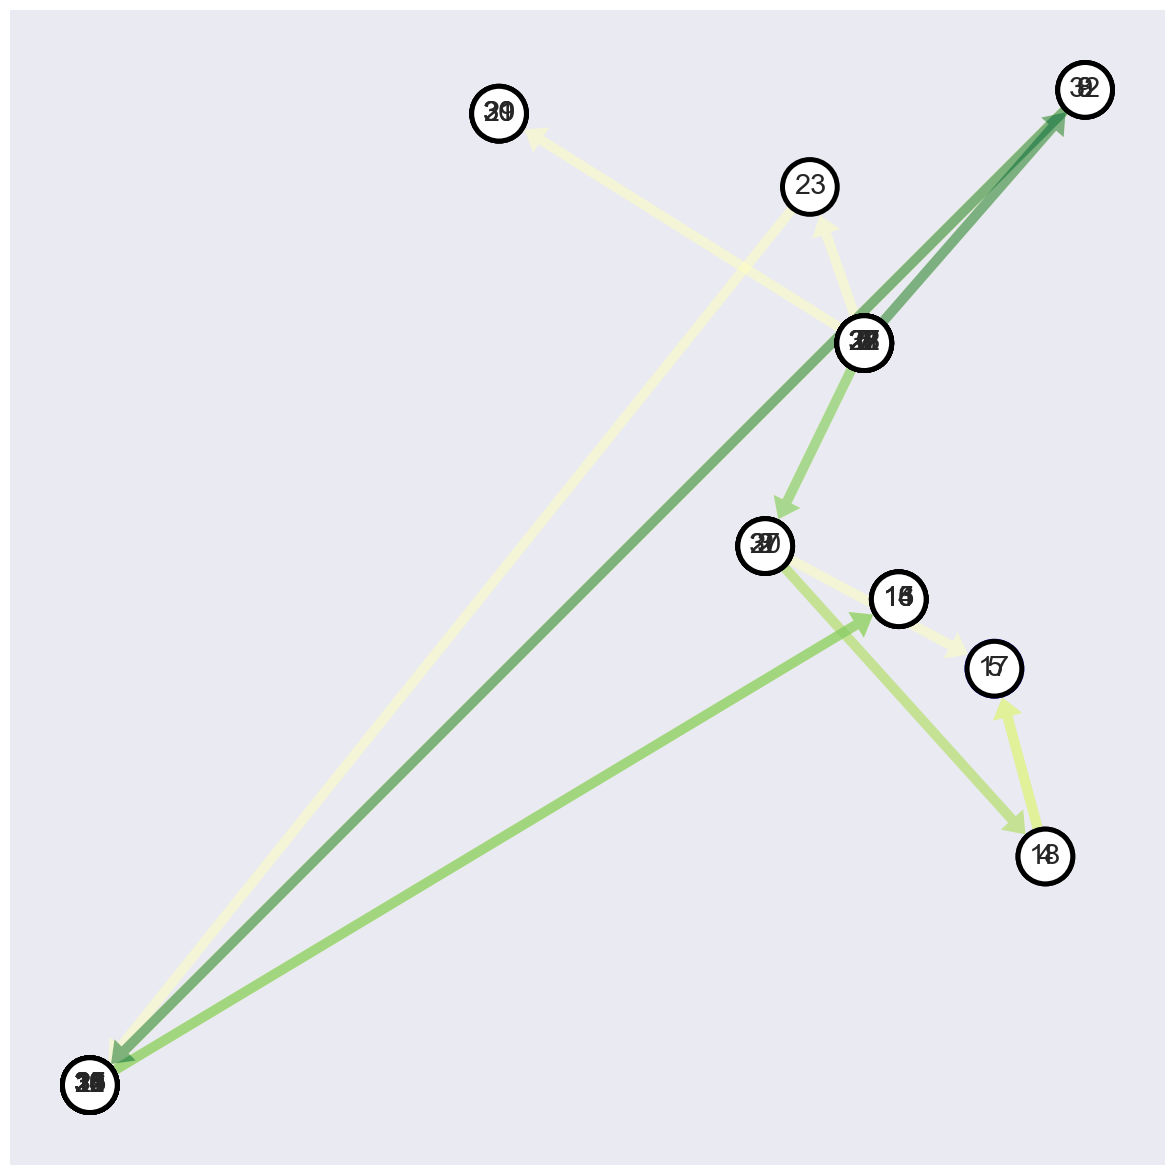

In [22]:
fig = plt.figure(figsize=(15, 15))
ta.hops_ip_model.plot_graph(fig.gca(), node_layout=final_pos)

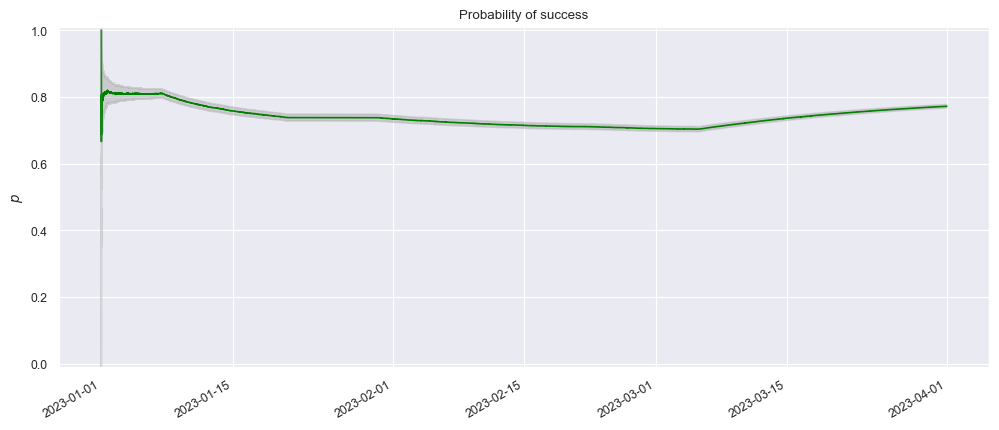

In [23]:
fig = plt.figure(figsize=(12, 5))
ta.destination_reached_model.plot(plt.gca())

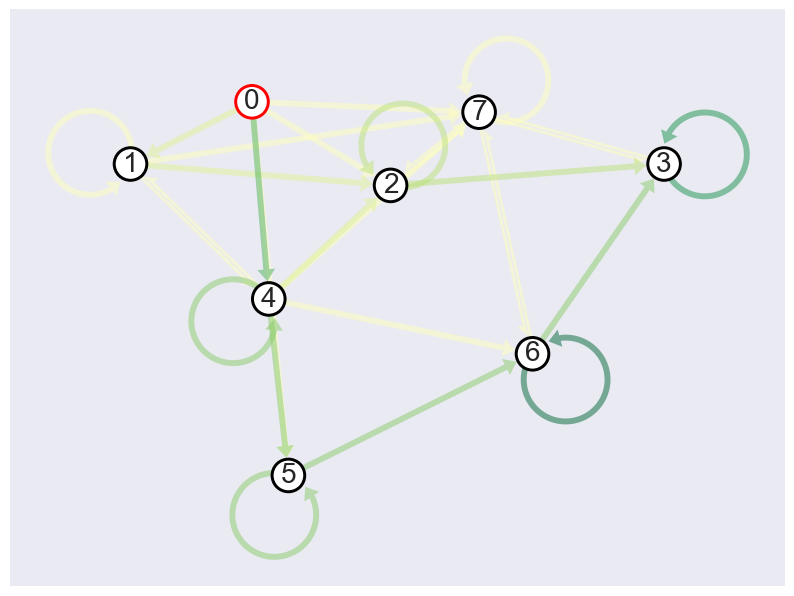

In [24]:
fig = plt.figure(figsize=(10, 10))
ta.hops_asn_model.plot_graph(plt.gca())

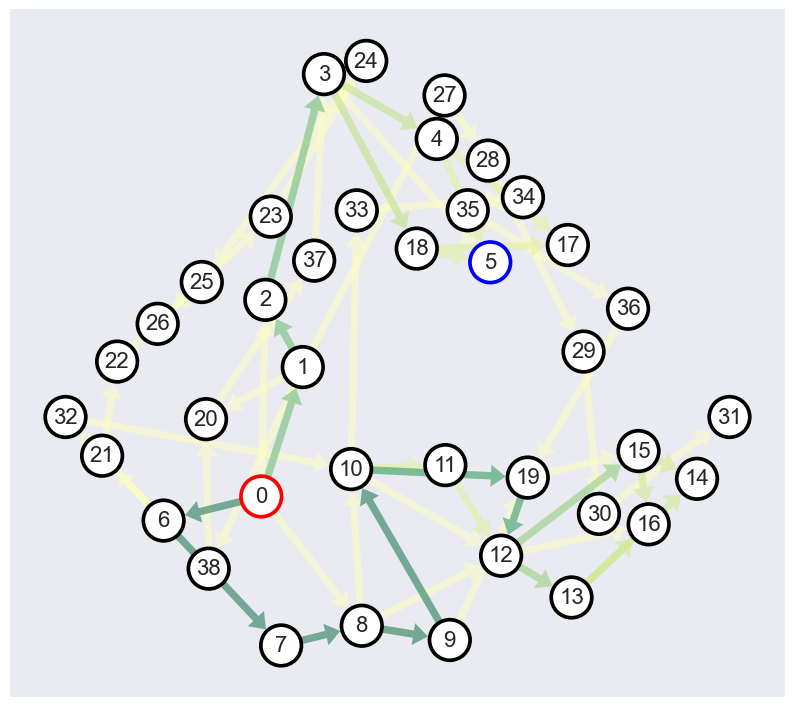

In [25]:
fig = plt.figure(figsize=(10, 10))
ta.hops_ip_model.plot_graph(plt.gca())

In [26]:
# ta.plot()

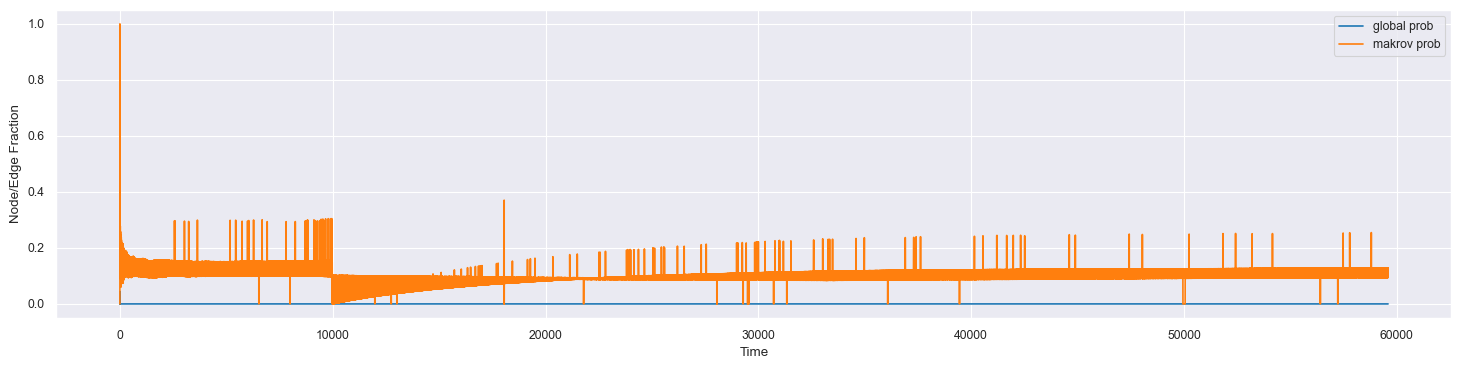

In [27]:
fig = plt.figure(figsize=(18, 4))
ax = plt.gca()
ta.hops_ip_model.plot(ax)
ax.legend()

In [28]:
tmp = ta.hops_ip_model.to_frame()

In [29]:
ts, path = zip(*ta.hops_ip_model.unique_paths)

In [30]:
x = pd.DataFrame({'path': path, 'ts':pd.to_datetime(ts, unit='ms')})

In [31]:
cc = x.groupby('path').agg({'ts': ['min', 'max']})

In [32]:
from trct.models import NormalModel

In [33]:
m = NormalModel(src, dest, )

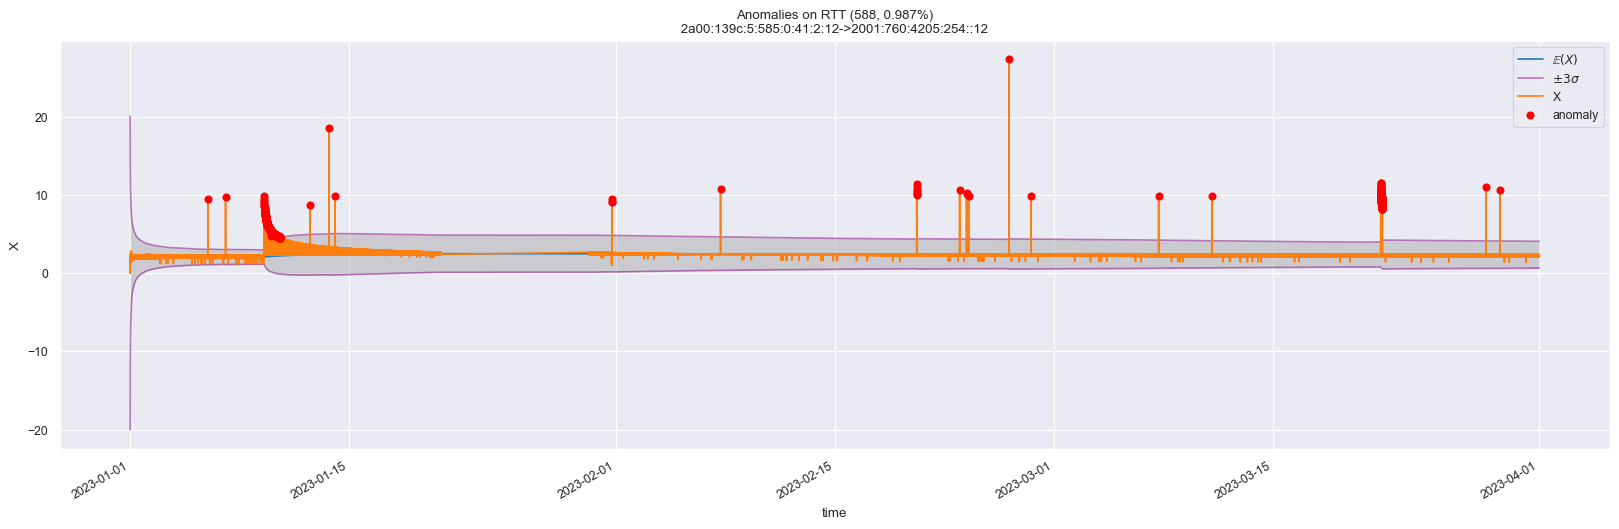

In [34]:
m = NormalModel(src, dest, alpha_0=3, mu_0=20, sigma_0=1)

for i,x in tmp['local_probs'].apply(np.log).items(): #diff
    if(np.isnan(x)):
        continue
    m.log(i.timestamp()*1000, -x)

fig = plt.figure(figsize=(20, 6))
m.plot(fig.gca())

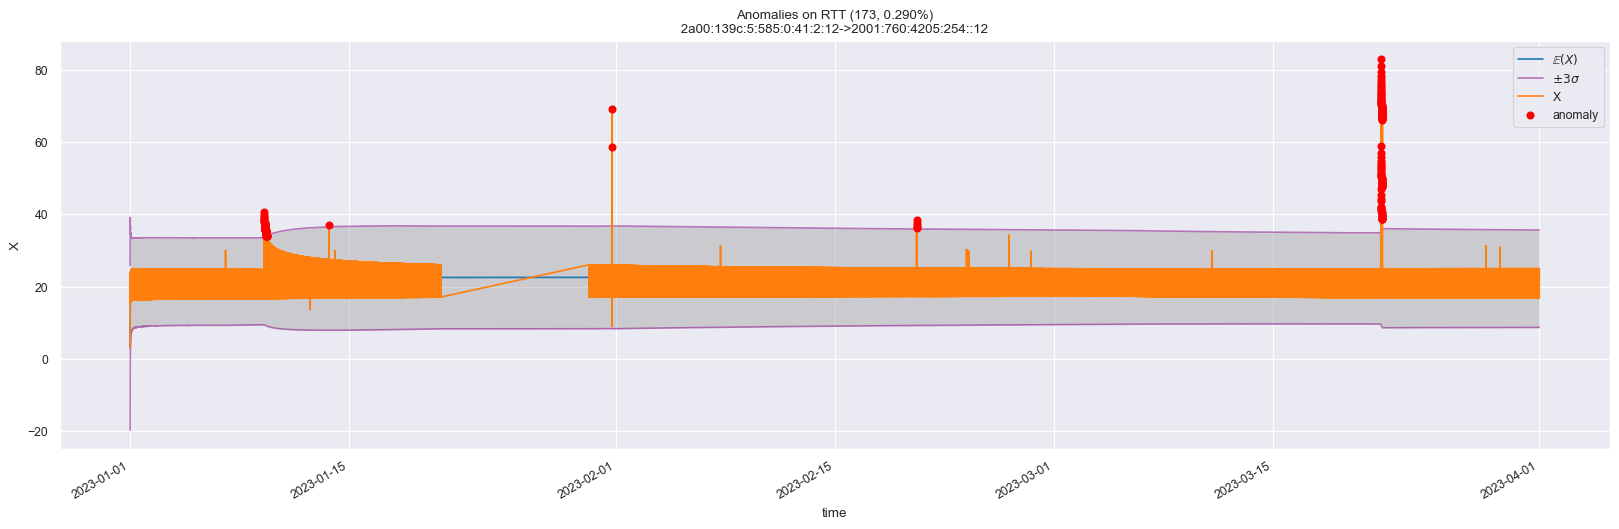

In [35]:
m = NormalModel(src, dest, alpha_0=1, mu_0=20, sigma_0=1)

for i,x in tmp['global_probs'].apply(np.log).items(): #diff
    if(np.isnan(x)):
        continue
    m.log(i.timestamp()*1000, -x)

fig = plt.figure(figsize=(20, 6))
m.plot(fig.gca())

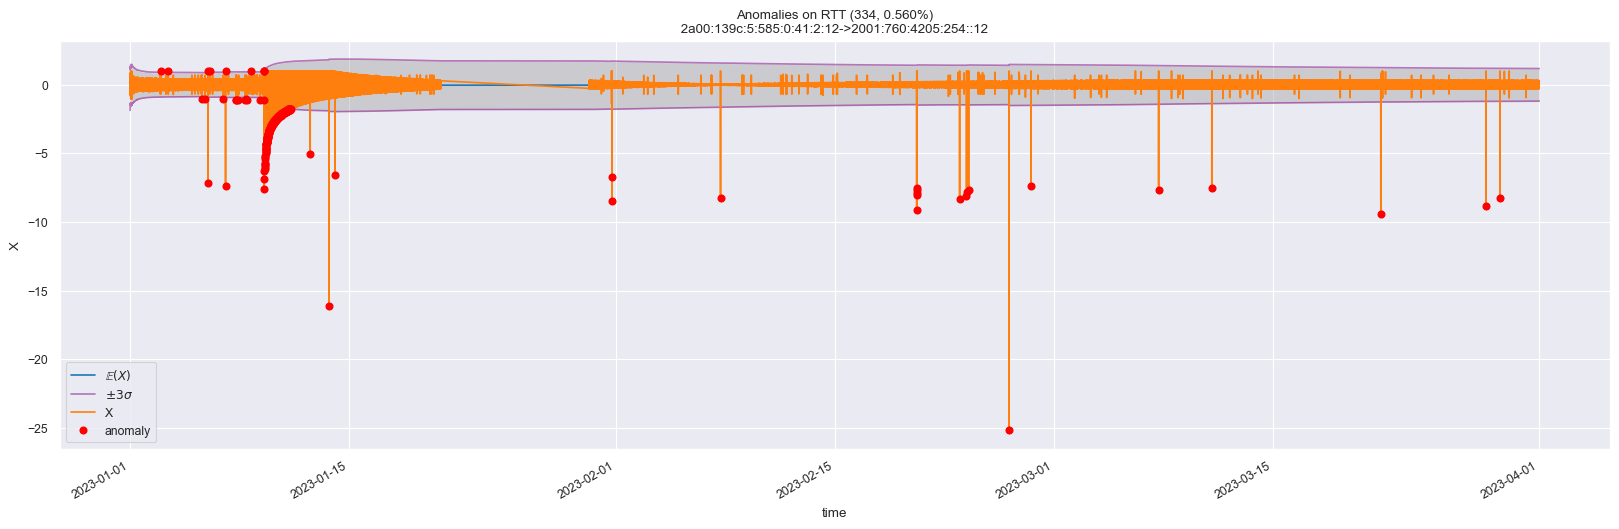

In [47]:
m = NormalModel(src, dest, alpha_0=3, mu_0=0, sigma_0=1)
 
for i,x in tmp['local_probs'].apply(np.log).diff().clip(-np.inf, 1).items(): #diff
    if(np.isnan(x)):
        continue
    m.log(i.timestamp()*1000, x)
fig = plt.figure(figsize=(20, 6))
m.plot(fig.gca())

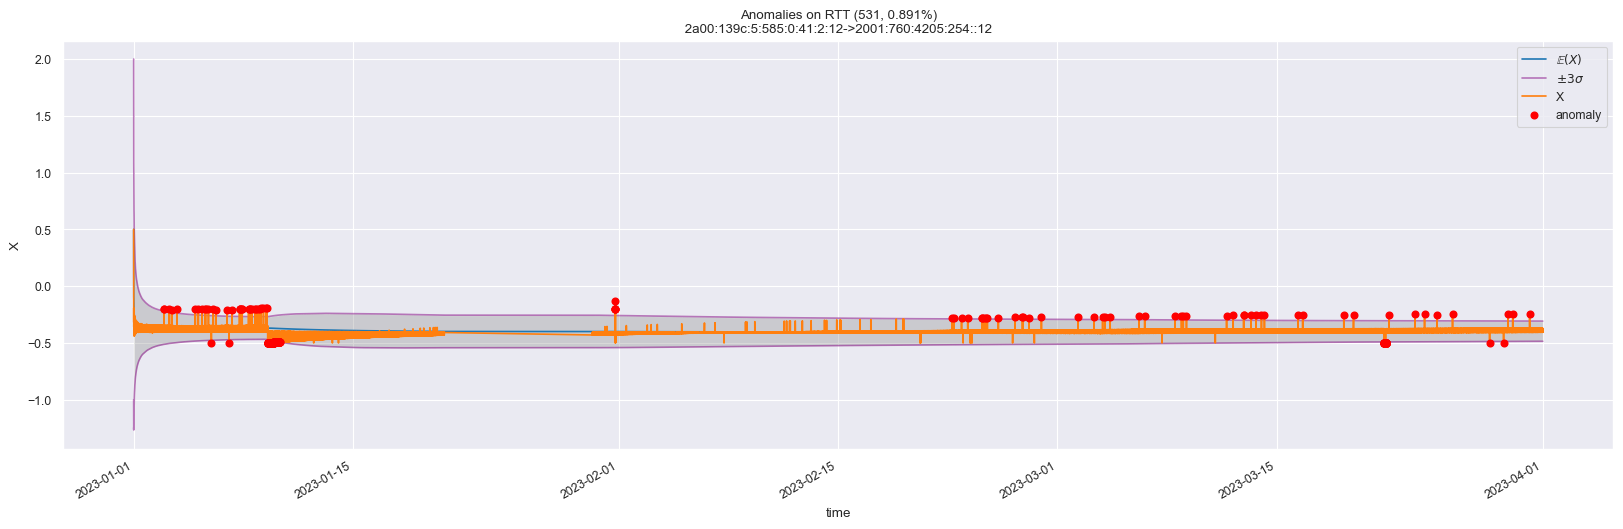

In [37]:
fig = plt.figure(figsize=(20, 6))
m.plot(fig.gca())

In [38]:
m = NormalModel(src, dest, alpha_0=3, mu_0=0, sigma_0=1)

for i,x in tmp['global_probs'].apply(np.log).items(): #diff
    if(np.isnan(x)):
        continue
    m.log(i.timestamp()*1000, x)

<AxesSubplot: >

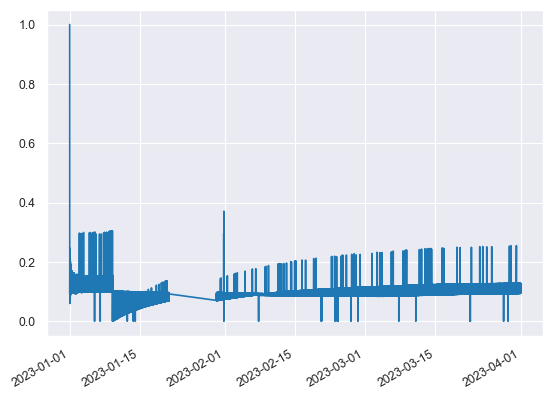

In [39]:
tmp['local_probs'].plot()

0.050225705223943214


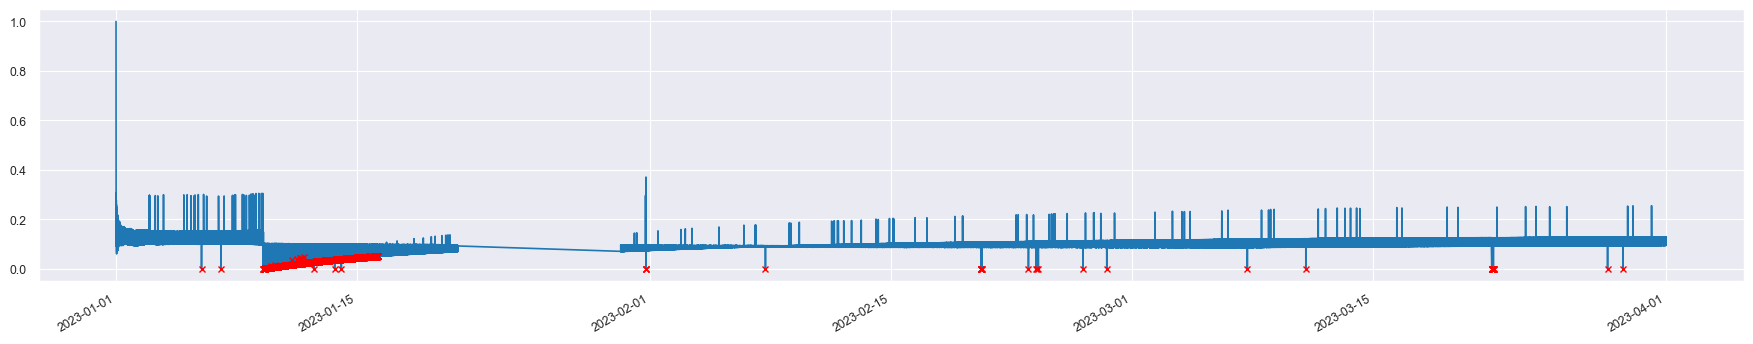

In [40]:
fig = plt.figure(figsize=(22, 4))
fig.gca().xaxis.set_label("p")
# (tmp['global_probs'] / tmp['local_probs']).diff().plot(ax=fig.gca())
x=(tmp['local_probs'])
x.plot(ax=fig.gca())
# (tmp['global_probs']-tmp['local_probs']).diff().plot(ax=fig.gca())
# (tmp['global_probs']).diff().plot(ax=fig.gca())
# (tmp['local_probs']).plot(ax=fig.gca())
# plt.plot(cc['ts']['min'], [0]*len(cc), 'o')
# plt.plot(cc['ts']['max'], [0]*len(cc), '>')
# (tmp['local_probs'][tmp['local_probs']<0.025]).plot(ax=fig.gca(), style='x')
# tmp[tmp['weighted_probs']<0.05]['weighted_probs'].plot(ax=fig.gca(), style='x')
x[x<(0.05)].plot(ax=fig.gca(), style='x', c='r')
# print(tmp[tmp['weighted_probs']<0.05]['weighted_probs'].shape)
print(x[x<(0.05)].shape[0]/x.shape[0])
# todo try path entropy

1.0


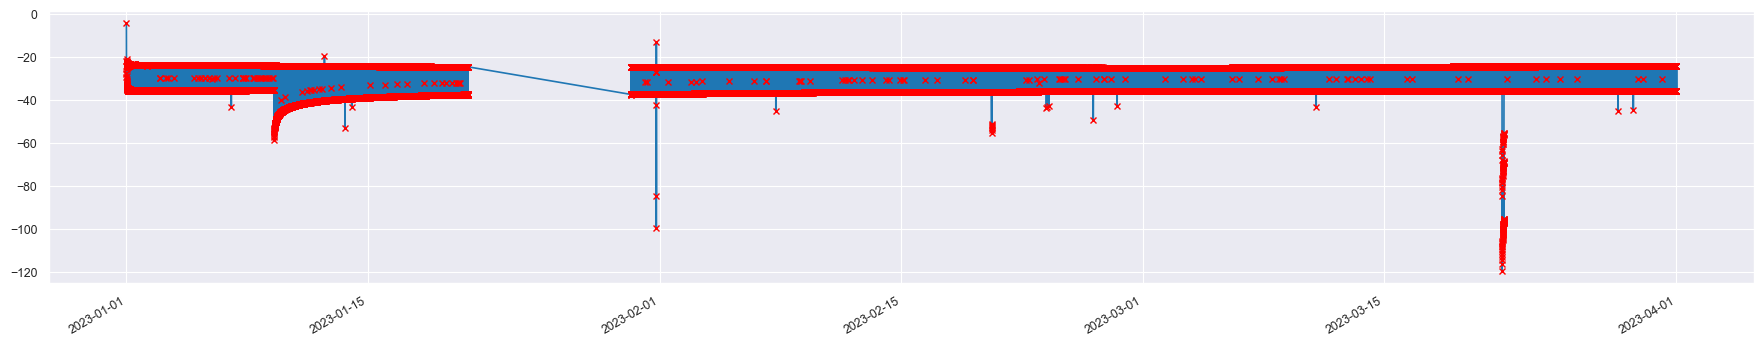

In [41]:
fig = plt.figure(figsize=(22, 4))
fig.gca().xaxis.set_label("p")
# (tmp['global_probs'] / tmp['local_probs']).diff().plot(ax=fig.gca())
x=((tmp['global_probs'].apply(np.log2)))
x.plot(ax=fig.gca())
# (tmp['global_probs']-tmp['local_probs']).diff().plot(ax=fig.gca())
# (tmp['global_probs']).diff().plot(ax=fig.gca())
# (tmp['local_probs']).plot(ax=fig.gca())
# plt.plot(cc['ts']['min'], [0]*len(cc), 'o')
# plt.plot(cc['ts']['max'], [0]*len(cc), '>')
# (tmp['local_probs'][tmp['local_probs']<0.025]).plot(ax=fig.gca(), style='x')
# tmp[tmp['weighted_probs']<0.05]['weighted_probs'].plot(ax=fig.gca(), style='x')
x[x<(0.01)].plot(ax=fig.gca(), style='x', c='r')
# print(tmp[tmp['weighted_probs']<0.05]['weighted_probs'].shape)
print(x[x<(0.005)].shape[0]/x.shape[0])

0.03534090718397073


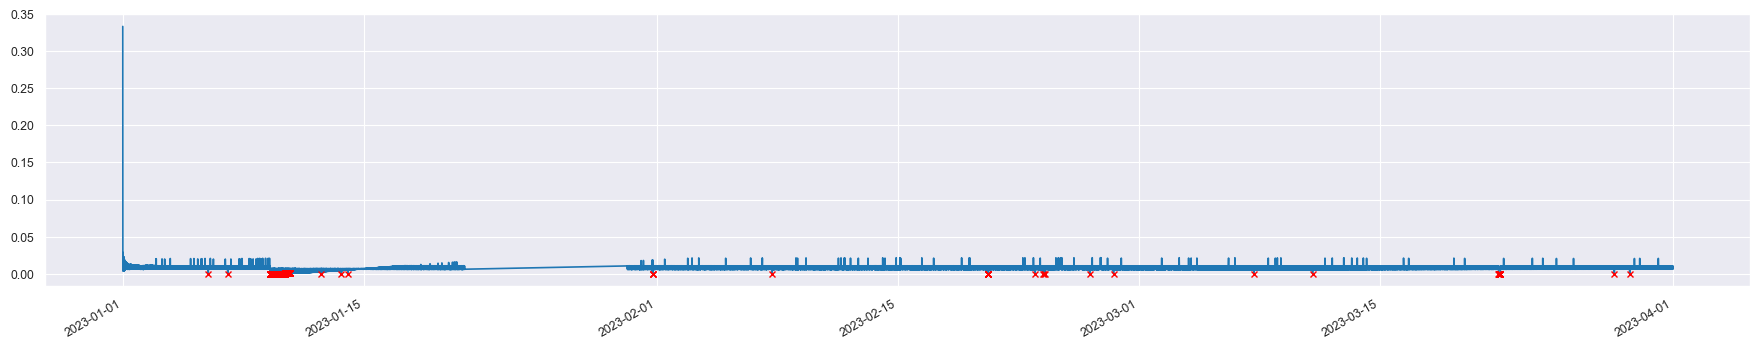

In [42]:
fig = plt.figure(figsize=(22, 4))
fig.gca().xaxis.set_label("p")
# (tmp['global_probs'] / tmp['local_probs']).diff().plot(ax=fig.gca())
x=((tmp['weighted_probs']))
x.plot(ax=fig.gca())
# (tmp['global_probs']-tmp['local_probs']).diff().plot(ax=fig.gca())
# (tmp['global_probs']).diff().plot(ax=fig.gca())
# (tmp['local_probs']).plot(ax=fig.gca())
# plt.plot(cc['ts']['min'], [0]*len(cc), 'o')
# plt.plot(cc['ts']['max'], [0]*len(cc), '>')
# (tmp['local_probs'][tmp['local_probs']<0.025]).plot(ax=fig.gca(), style='x')
# tmp[tmp['weighted_probs']<0.05]['weighted_probs'].plot(ax=fig.gca(), style='x')
x[x<(0.0005)].plot(ax=fig.gca(), style='x', c='r')
# print(tmp[tmp['weighted_probs']<0.05]['weighted_probs'].shape)
print(x[x<(0.005)].shape[0]/x.shape[0])